In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods)
    data['std'] = data['roc'].ewm(span=200).std()
    data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
sym = 'NQ'
start_date='20180901'
periods=[5,10,20,40,80,160]
inds = {
    'bollir': run(sym, bolli_reduced, start_date=start_date, periods=periods), 
    'ema': run(sym, ema, start_date=start_date, periods=periods), 
    'breakout': run(sym, breakout, start_date=start_date, periods=periods),
    'carver': run(sym, carver, adjustment=40, start_date=start_date, periods=periods),
    'roc': run(sym, roc, start_date=start_date, periods=periods)
}
weights = {
    'bollir': .5, 
    'ema': .25, 
    'breakout': .25,
    #'carver': .1,
    #'roc': .1,
}

In [10]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
bollir,8.76024,5.78312
ema,9.85573,6.23525
breakout,10.7126,6.4889
carver,9.4531,5.98241
roc,10.3015,5.58594


In [11]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,bollir,ema,breakout,carver,roc
bollir,1.000000,0.661069,0.928298,0.935429,0.799394
ema,0.661069,1.000000,0.700349,0.704188,0.906481
breakout,0.928298,0.700349,1.000000,0.932547,0.828697
carver,0.935429,0.704188,0.932547,1.000000,0.838188
roc,0.799394,0.906481,0.828697,0.838188,1.000000


In [12]:
c.sum()

bollir      4.324192
ema         3.972087
breakout    4.389891
carver      4.410352
roc         4.372760
dtype: float64

In [13]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()})
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df

In [14]:
data=combine(inds, )

In [15]:
data.forecast.abs().mean(), data.forecast.abs().std()

(9.218906359331644, 5.514230274286466)

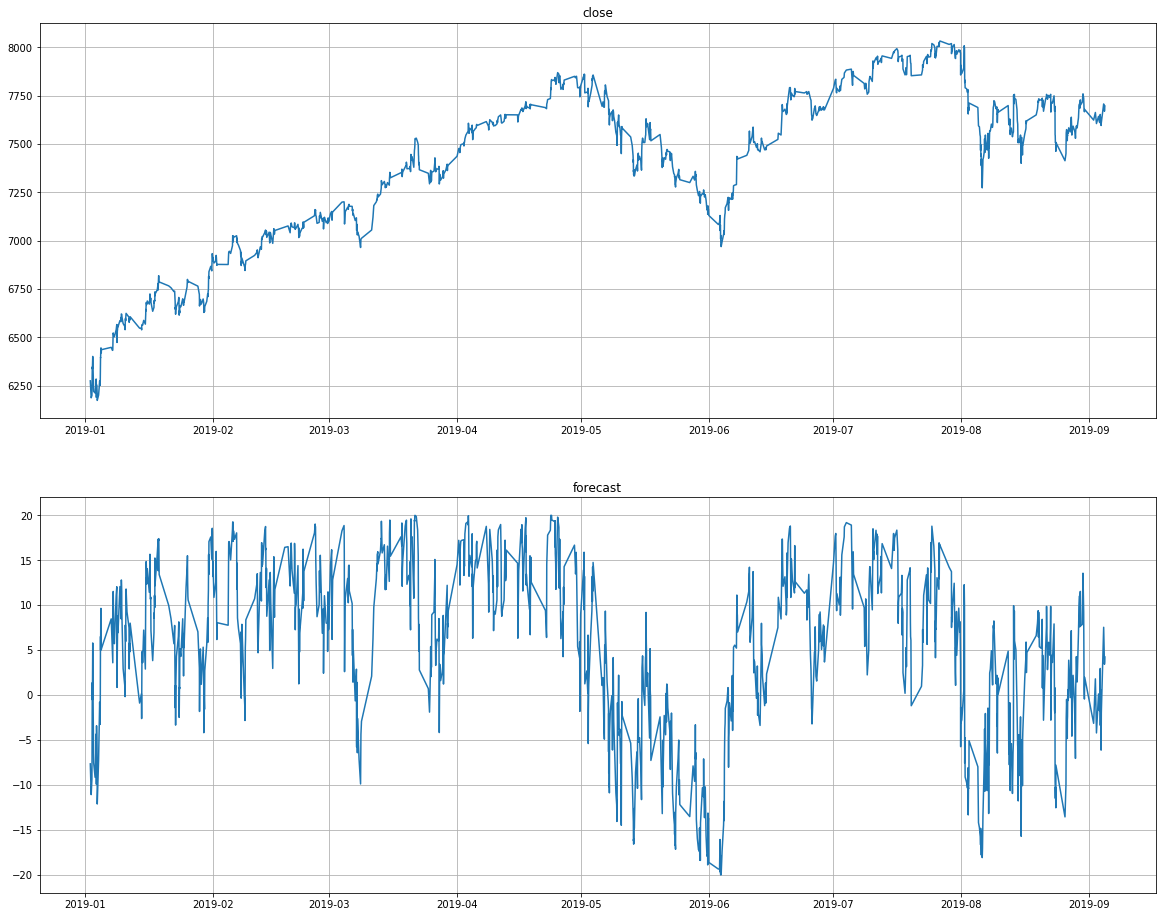

In [16]:
plot(data[['close', 'forecast']])

In [17]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.303913,0.227124,0.161081,0.169592,0.0197725,0.0480959,-0.0768012,-0.0903815,-0.00876624
Cumulative returns,0.204893,0.154605,0.110601,0.116313,0.0138473,0.0335448,-0.0545816,-0.0643713,-0.0061653
Annual volatility,0.173381,0.1528,0.151912,0.137795,0.143099,0.110028,0.067541,0.0489425,0.0212095
Sharpe ratio,1.61745,1.41575,1.05872,1.20552,0.207799,0.481541,-1.14953,-1.91087,-0.404617
Calmar ratio,3.65383,3.68289,2.4306,2.74129,0.254241,0.888889,-1.27382,-1.23858,-0.667233
Stability,0.949448,0.891438,0.870579,0.886058,0.691608,0.424304,0.754953,0.80456,0.186748
Max drawdown,-0.0831766,-0.0616701,-0.066272,-0.0618658,-0.0777707,-0.0541079,-0.0602919,-0.0729718,-0.0131382
Omega ratio,1.31254,1.26442,1.1966,1.22609,1.03634,1.09612,0.719819,0.532397,0.808371
Sortino ratio,2.47816,2.28608,1.68778,1.94578,0.314337,0.750914,-1.75427,-2.53666,-0.662584
Skew,0.0509373,0.38581,0.428084,0.431997,0.421717,0.530931,1.81244,0.83189,3.17672


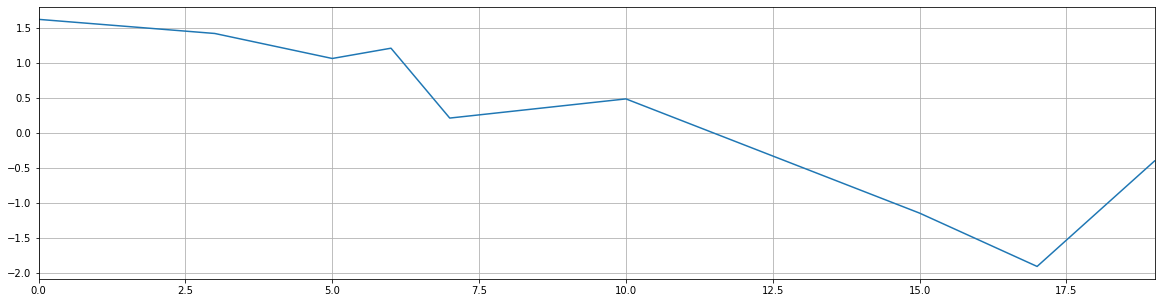

In [18]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [19]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.898333,0.803090,0.755834,0.711918,0.608573,0.302019,0.209835,0.143526
3,0.898333,1.000000,0.926697,0.885084,0.848706,0.733591,0.375580,0.244796,0.166367
5,0.803090,0.926697,1.000000,0.957557,0.918212,0.781934,0.428101,0.286908,0.175376
6,0.755834,0.885084,0.957557,1.000000,0.961567,0.815863,0.470136,0.280114,0.183269
7,0.711918,0.848706,0.918212,0.961567,1.000000,0.854585,0.510950,0.284795,0.185506
10,0.608573,0.733591,0.781934,0.815863,0.854585,1.000000,0.581864,0.336266,0.183800
15,0.302019,0.375580,0.428101,0.470136,0.510950,0.581864,1.000000,0.639549,0.309344
17,0.209835,0.244796,0.286908,0.280114,0.284795,0.336266,0.639549,1.000000,0.492064
19,0.143526,0.166367,0.175376,0.183269,0.185506,0.183800,0.309344,0.492064,1.000000


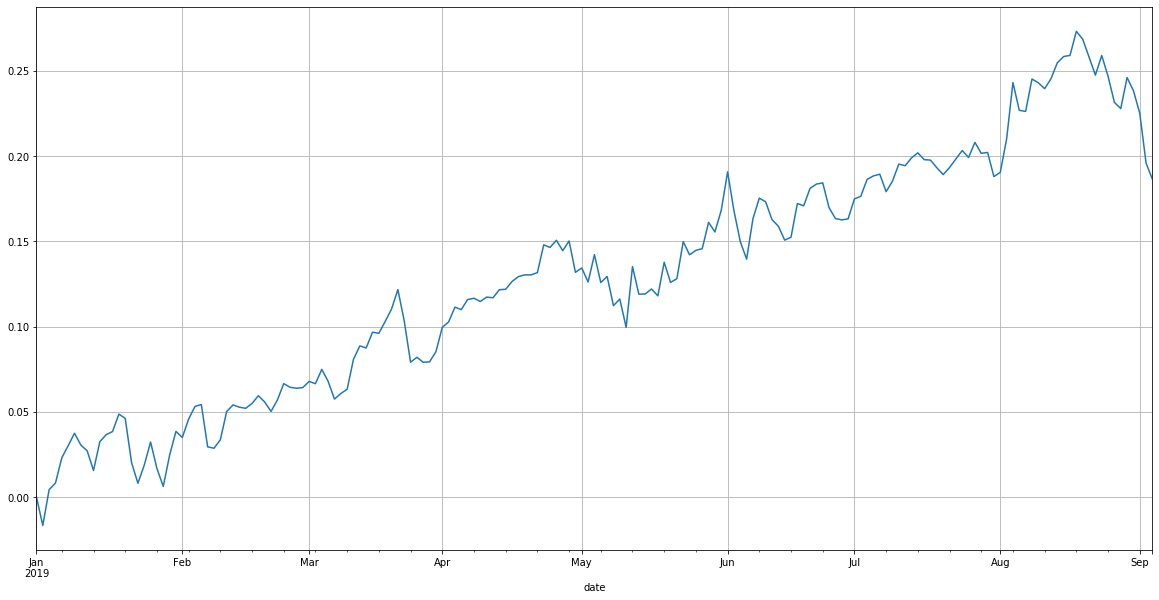

In [20]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

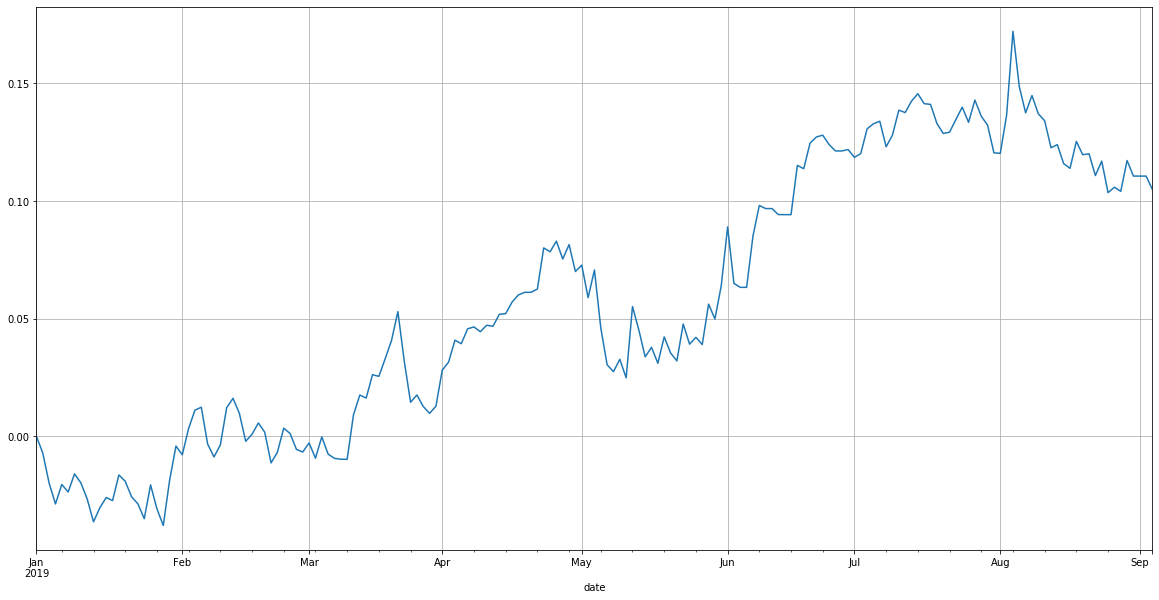

In [21]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

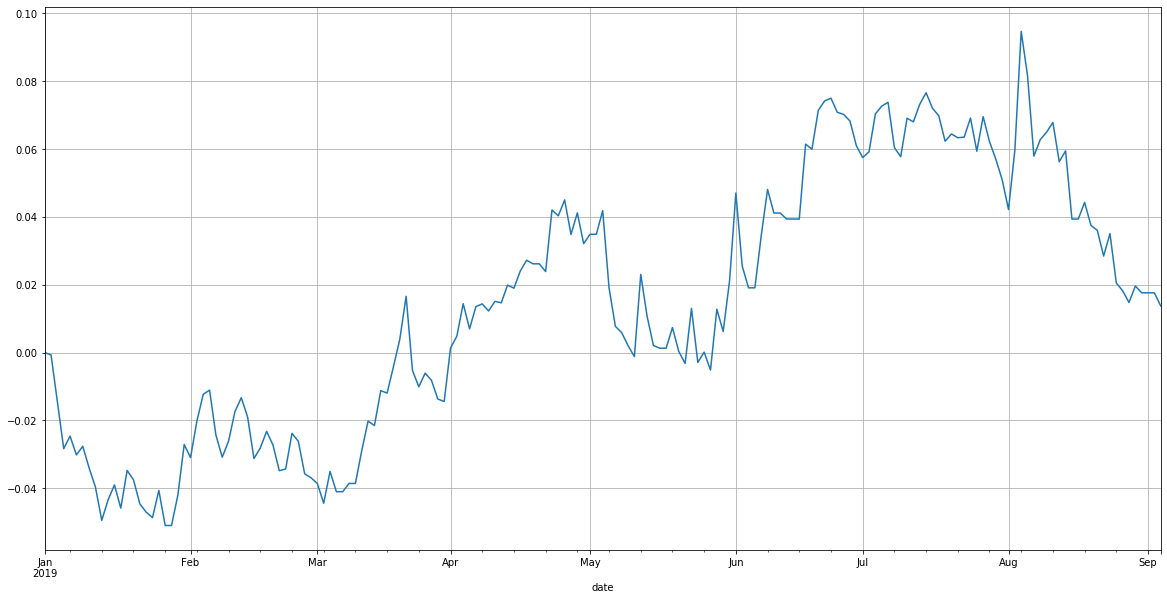

In [22]:
np.log(out.returns[7]+1).cumsum().plot(figsize=(20, 10), grid=True);

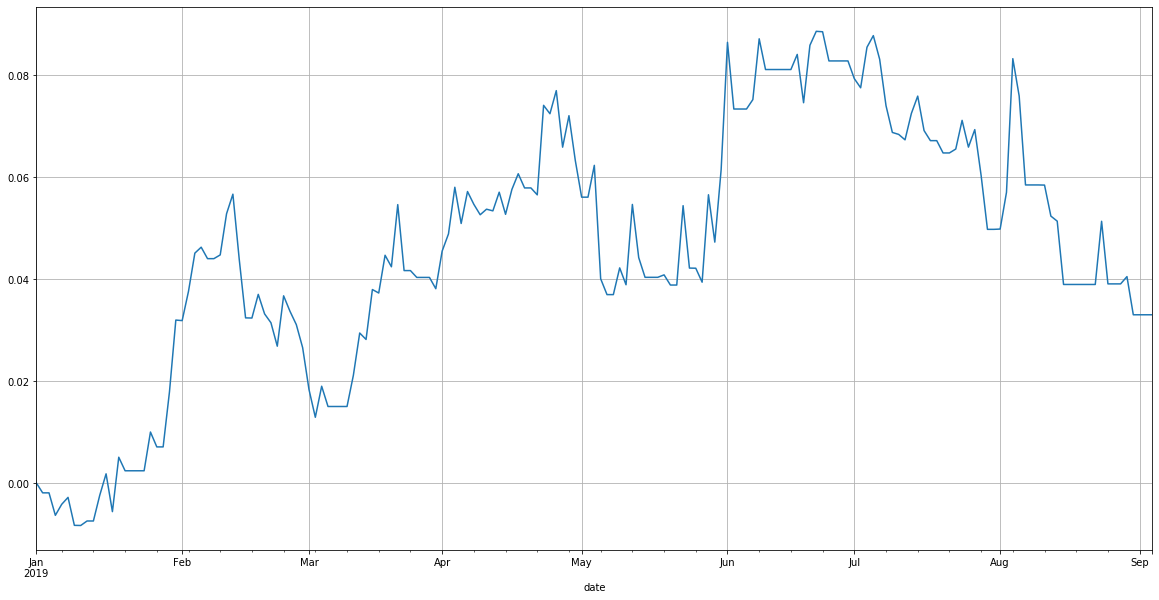

In [23]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);